<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/data_ingestion_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os

In [ ]:
!pip install -qqq wfdb resampy icd-mappings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 117.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

from icdmappings import Mapper
import argparse
import pandas as pd
import numpy as np
from pathlib import Path
import wfdb
from tqdm.auto import tqdm
from extract_headers import extract_and_open_files_in_zip

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

# from icdmappings import Mapper
from ecg_utils import prepare_mimicecg
from mimic_ecg_preprocessing import prepare_mimic_ecg

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src/utils')

from timeseries_utils import reformat_as_memmap
from stratify import stratified_subsets

In [ ]:
project_path = "/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/"

In [ ]:
mimic_path = Path(project_path + "mimic-iv-2.2")
zip_file_path = Path(project_path + "MIMIC-IV-ECG zip file/mimic-iv-ecg.zip")
target_path = Path(project_path + "src/preprocessed_data",)

print("MIMIC Path:", mimic_path)
print("Zip Path:", zip_file_path)
print("Target Path:", target_path)

MIMIC Path: /content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/mimic-iv-2.2
Zip Path: /content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/MIMIC-IV-ECG zip file/mimic-iv-ecg.zip
Target Path: /content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src/preprocessed_data


## Step 1: Extract available records from mimic-ecg-zip-path to create records.pkl

In [ ]:
if(Path(project_path+"records.pkl").exists()):
    print("Skipping: using existing records.pkl")
    df = pd.read_pickle(project_path+"records.pkl")
else:
    print("Creating records.pkl")
    df=extract_and_open_files_in_zip(zip_file_path, ".hea")
    df.to_pickle(project_path / "records.pkl")

Skipping: using existing records.pkl


In [ ]:
print("Contents of records.pkl file")
df.head()

Contents of records.pkl file


,filename,study_id,patient_id,ecg_time
0,mimic-iv-ecg/files/p1188/p11887165/s43591201/4...,43591201,11887165,2189-05-18 07:56:00
1,mimic-iv-ecg/files/p1188/p11887165/s49748010/4...,49748010,11887165,2189-06-01 11:05:00
2,mimic-iv-ecg/files/p1188/p11887165/s49403776/4...,49403776,11887165,2189-05-20 16:40:00
3,mimic-iv-ecg/files/p1188/p11887165/s43634761/4...,43634761,11887165,2189-05-31 10:42:00
4,mimic-iv-ecg/files/p1188/p11887165/s45332981/4...,45332981,11887165,2189-06-02 10:32:00


## Step 2: Extract diagnoses for records in raw format to create records_w_diag.pkl

### [Preview] Diagnoses with ICD codes and description

In [ ]:
mapper = Mapper()

df_hosp_icd_description = pd.read_csv(mimic_path/"hosp/d_icd_diagnoses.csv.gz")
print("df_hosp_icd_description",df_hosp_icd_description.shape)

#creating mapping of icd9 to icd10
df_hosp_icd_description["icd10_code"]=df_hosp_icd_description.apply(lambda row:row["icd_code"] if row["icd_version"]==10 else mapper.map(row["icd_code"], source="icd9", target="icd10"),axis=1)#mapper="icd9toicd10"
#creates a key value pair mapping from icd9 to icd10
icd_mapping = {ic:ic10 for ic,ic10 in zip(df_hosp_icd_description["icd_code"],df_hosp_icd_description["icd10_code"])}

print("\nContents of d_icd_diagnoses.csv.gz:\n")
print(df_hosp_icd_description.head())


df_hosp_icd_description (109775, 3)

Contents of d_icd_diagnoses.csv.gz:

  icd_code  icd_version                             long_title icd10_code
0     0010            9         Cholera due to vibrio cholerae       A000
1     0011            9  Cholera due to vibrio cholerae el tor       A001
2     0019            9                   Cholera, unspecified       A009
3     0020            9                          Typhoid fever      A0100
4     0021            9                    Paratyphoid fever A       A011


### Getting the admission records for hosp and ed stays that falls within the ecg time


get_diagnosis_hosp outputs:
- A list of ICD codes representing the diagnoses associated with the patient's hospital admission during the ECG time.

- The hadm_id (hospital admission ID). If no matching admission was found, it returns an empty list and np.nan.

In [ ]:
def get_diagnosis_hosp(patient_id, ecg_time):
    # Get the hospital admission record for the patient_id within the ECG time
    df_ecg_during_hosp = df_hosp_admissions[(df_hosp_admissions.subject_id==patient_id) & (df_hosp_admissions.admittime<ecg_time) & ((df_hosp_admissions.dischtime>ecg_time)|(df_hosp_admissions.deathtime>ecg_time))]
    if(len(df_ecg_during_hosp)==0):
        return [],np.nan
    else:
        if(len(df_ecg_during_hosp)>1):
            print("Error in get_diagnosis_hosp: multiple entries for",patient_id,ecg_time,". Considering only the first one.")
        hadm_id=df_ecg_during_hosp.hadm_id.iloc[0]
        return list(df_hosp_icd_diagnoses[(df_hosp_icd_diagnoses.subject_id==patient_id)&(df_hosp_icd_diagnoses.hadm_id==hadm_id)].sort_values(by=['seq_num']).icd_code), hadm_id #diags_hosp, hadm_id

get_diagnosis_ed outputs:

**Aims to return ED diagnoses (res) and the ED stay ID (stay_id).**

- If also_hosp_diag is True, it additionally provides hospital admission diagnoses (res2) and the admission ID (hadm_id) if available.

- If no matching ED stay is found, it returns empty lists and np.nan for IDs, indicating no relevant data.

In [ ]:
def get_diagnosis_ed(patient_id, ecg_time,also_hosp_diag=True):
    df_ecg_during_ed = df_ed_stays[(df_ed_stays.subject_id==patient_id) & (df_ed_stays.intime<ecg_time) & (df_ed_stays.outtime>ecg_time)]
    if(len(df_ecg_during_ed)==0):
        return ([],[],np.nan,np.nan) if also_hosp_diag else ([],np.nan)
    else:
        if(len(df_ecg_during_ed)>1):
            print("Error in get_diagnosis_ed: multiple entries for",patient_id,ecg_time,". Considering only the first one.")
        stay_id=df_ecg_during_ed.stay_id.iloc[0]
        hadm_id=df_ecg_during_ed.hadm_id.iloc[0]#potentially none
        res=list(df_ed_diagnosis[(df_ed_diagnosis.subject_id==patient_id)&(df_ed_diagnosis.hadm_id==stay_id)].sort_values(by=['seq_num']).icd_code)
        if(also_hosp_diag):
            res2=list(df_hosp_icd_diagnoses[(df_hosp_icd_diagnoses.subject_id==patient_id)&(df_hosp_icd_diagnoses.hadm_id==hadm_id)].sort_values(by=['seq_num']).icd_code)
            return res, res2, stay_id, (np.nan if hadm_id is None else hadm_id) #diags_ed, diags_hosp, stay_id, hadm_id
        else:
            return res, stay_id #diags_ed, stay_id

In [ ]:
df_hosp_icd_diagnoses = pd.read_csv(mimic_path/"hosp/diagnoses_icd.csv.gz")
print("df_hosp_icd_diagnoses",df_hosp_icd_diagnoses.shape)

df_hosp_icd_diagnoses (4756326, 5)


In [ ]:
df_hosp_admissions = pd.read_csv(mimic_path/"hosp/admissions.csv.gz")
print("df_hosp_admissions",df_hosp_admissions.shape)

df_hosp_admissions (431231, 16)


In [ ]:
df_ed_stays = pd.read_csv(mimic_path/"icu/icustays.csv.gz")
print("df_ed_stays",df_ed_stays.shape)

df_ed_stays (73181, 8)


In [ ]:
if((target_path/"records_w_diag.pkl").exists()):
    print("Skipping: using existing records_w_diag.pkl")
    df_full = pd.read_pickle(target_path/"records_w_diag.pkl")
else:
    print("Creating records_w_diag.pkl")
    df_hosp_admissions["admittime"]=pd.to_datetime(df_hosp_admissions["admittime"])
    df_hosp_admissions["dischtime"]=pd.to_datetime(df_hosp_admissions["dischtime"]) #discharge time
    df_hosp_admissions["deathtime"]=pd.to_datetime(df_hosp_admissions["deathtime"])


    df_ed_stays["intime"]=pd.to_datetime(df_ed_stays["intime"])
    df_ed_stays["outtime"]=pd.to_datetime(df_ed_stays["outtime"])
    df_ed_diagnosis = pd.read_csv(mimic_path/"hosp/diagnoses_icd.csv.gz")

    result=[]
    for id,row in tqdm(df.iterrows(),total=len(df)):
        tmp={}
        tmp["filename"]=row["filename"]
        tmp["study_id"]=row["study_id"]
        tmp["patient_id"]=row["patient_id"]
        tmp["ecg_time"]=row["ecg_time"]
        hosp_diag_hosp, hosp_hadm_id =get_diagnosis_hosp(row["patient_id"], row["ecg_time"])
        tmp["hosp_diag_hosp"] = hosp_diag_hosp
        tmp["hosp_hadm_id"] =hosp_hadm_id
        ed_diag_ed,ed_diag_hosp,ed_stay_id,ed_hadm_id = get_diagnosis_ed(row["patient_id"], row["ecg_time"])
        tmp["ed_diag_ed"]=ed_diag_ed
        tmp["ed_diag_hosp"]=ed_diag_hosp
        tmp["ed_stay_id"]=ed_stay_id
        tmp["ed_hadm_id"]=ed_hadm_id
        result.append(tmp)

    df_full = pd.DataFrame(result)
    df_full["hosp_diag_hosp"]=df_full["hosp_diag_hosp"].apply(lambda x: [] if x is None else x)
    df_full.to_pickle(target_path/"records_w_diag.pkl")

Skipping: using existing records_w_diag.pkl


In [ ]:
# df_full = pd.read_pickle(target_path/"records_w_diag.pkl")
df_full.head()

,filename,study_id,patient_id,ecg_time,hosp_diag_hosp,hosp_hadm_id,ed_diag_ed,ed_diag_hosp,ed_stay_id,ed_hadm_id
0,mimic-iv-ecg/files/p1188/p11887165/s43591201/4...,43591201,11887165,2189-05-18 07:56:00,"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",23708811.0,[],"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",38768187.0,23708811.0
1,mimic-iv-ecg/files/p1188/p11887165/s49748010/4...,49748010,11887165,2189-06-01 11:05:00,"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",23708811.0,[],[],NaN,NaN
2,mimic-iv-ecg/files/p1188/p11887165/s49403776/4...,49403776,11887165,2189-05-20 16:40:00,"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",23708811.0,[],"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",38768187.0,23708811.0
3,mimic-iv-ecg/files/p1188/p11887165/s43634761/4...,43634761,11887165,2189-05-31 10:42:00,"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",23708811.0,[],[],NaN,NaN
4,mimic-iv-ecg/files/p1188/p11887165/s45332981/4...,45332981,11887165,2189-06-02 10:32:00,"[S066X9A, J156, J9601, E873, J811, R1310, F05,...",23708811.0,[],[],NaN,NaN


## Step 3: Map everything to ICD10 and enrich with more metadata to create output records_w_diag_icd10.pkl


In [ ]:
def prepare_mimic_ecg(digits, target_folder, df_mapped=None, df_diags=None):

    print("preparing MIMIC ECG dataset for finetuning")

    # load label dataframe
    if df_diags is not None:
        df_diags = df_diags
    else:
        if((target_folder/"records_w_diag_icd10.pkl").exists()):
            df_diags = pd.read_pickle(target_folder/"records_w_diag_icd10.pkl")
        else:
            df_diags = pd.read_csv(target_folder/"records_w_diag_icd10.csv")
            # df_diags.drop('Unnamed: 0',axis=1, inplace=True)
            df_diags['ecg_time']=pd.to_datetime(df_diags["ecg_time"])
            df_diags['dod']=pd.to_datetime(df_diags["dod"])
            for c in ['ed_diag_ed', 'ed_diag_hosp', 'hosp_diag_hosp', 'all_diag_hosp', 'all_diag_all']:
                df_diags[c]=df_diags[c].apply(lambda x: eval(x))

    df_diags["label_train"]=df_diags["all_diag_all"]
    df_diags["has_statements_train"]=df_diags["label_train"].apply(lambda x: len(x)>0)#keep track if there were any ICD statements for this sample


    #first truncate to desired number of digits
    if(digits is not None):
        df_diags["label_train"]=df_diags["label_train"].apply(lambda x: list(set([y.strip()[:digits] for y in x])))

    #remove trailing placeholder Xs
    df_diags["label_train"]=df_diags["label_train"].apply(lambda x: list(set([y.rstrip("X") for y in x])))

    print("filter stroke")
    #no selection = apply, specific icd codes that are linked to stroke
    target_icd_codes = ("I481", "R000", "R001", "I210", "I200", "I20", "I21", "I24", "I25", "I42", "E87", "I48", "I44", "I45", "E1129", "E11", "J44", "J45")
    df_diags["label_stroke"] = df_diags["label_train"].apply(lambda x: [c for c in x if any(c.startswith(p) for p in target_icd_codes)]) # Keep codes that start with any prefix

    return df_diags

In [ ]:
if((target_path/"records_w_diag_icd10.pkl").exists()):
    print("Skipping: using existing records_w_diag_icd10.pkl")
    df_full = pd.read_pickle(target_path/"records_w_stroke_labels.csv")
else:
    #applying icd mapping, skip none and NoDx
    df_full["hosp_diag_hosp"]=df_full["hosp_diag_hosp"].apply(lambda x: [icd_mapping[y] for y in x])
    df_full["hosp_diag_hosp"]=df_full["hosp_diag_hosp"].apply(lambda x: list(set([y for y in x if (y!="NoDx" and y!=None)])))
    df_full["ed_diag_hosp"]=df_full["ed_diag_hosp"].apply(lambda x: [icd_mapping[y] for y in x])
    df_full["ed_diag_hosp"]=df_full["ed_diag_hosp"].apply(lambda x: list(set([y for y in x if (y!="NoDx" and y!=None)])))
    df_full["ed_diag_ed"]=df_full["ed_diag_ed"].apply(lambda x: [icd_mapping[y] for y in x if y!="NoDx"])
    df_full["ed_diag_ed"]=df_full["ed_diag_ed"].apply(lambda x: list(set([y for y in x if (y!="NoDx" and y!=None)])))

    # create a column of all the icd codes for hosp and ed stays respectively
    #ed or hosp ecgs with discharge diagnosis
    df_full["all_diag_hosp"]=df_full.apply(lambda row: list(set(row["hosp_diag_hosp"]+row["ed_diag_hosp"])),axis=1)

    # 'all_diag_all': 'all_diag_hosp' if available otherwise 'ed_diag_ed'
    df_full['all_diag_all'] = df_full.apply(lambda row: row['all_diag_hosp'] if row['all_diag_hosp'] else row['ed_diag_ed'],axis=1)


    #add demographics
    df_hosp_patients = pd.read_csv(mimic_path/"hosp/patients.csv.gz")
    df_full=df_full.join(df_hosp_patients.set_index("subject_id"),on="patient_id")

    #add ecg number within stay
    df_full["ecg_no_within_stay"]=-1
    df_full=df_full.sort_values(["patient_id","ecg_time"],ascending=True)

    #groups all the ecg within the same stay and count the number of ecg record taken for each stay
    df_full.loc[~df_full.ed_stay_id.isna(),"ecg_no_within_stay"]=df_full[~df_full.ed_stay_id.isna()].groupby("ed_stay_id",as_index=False).cumcount()
    df_full.loc[~df_full.hosp_hadm_id.isna(),"ecg_no_within_stay"]=df_full[~df_full.hosp_hadm_id.isna()].groupby("hosp_hadm_id",as_index=False).cumcount()


    df_full["ecg_taken_in_ed"]=df_full["ed_stay_id"].notnull()
    df_full["ecg_taken_in_hosp"]=df_full["hosp_hadm_id"].notnull()
    df_full["ecg_taken_in_ed_or_hosp"]=(df_full["ecg_taken_in_ed"]|df_full["ecg_taken_in_hosp"])


    df_full = prepare_mimic_ecg(3, target_path,df_mapped=None,df_diags=df_full)

    # res = stratified_subsets(df_full,
    #                 col_label,
    #                 [0.05]*20,
    #                 col_group=col_group,
    #                 label_multi_hot=False,
    #                 random_seed=42)

    # df_full['strat_fold'] = res

    df_full.to_csv(target_path/"records_w_stroke_labels.csv", index=False)


preparing MIMIC ECG dataset for finetuning
filter stroke


# Step 3.5: Multihot encode: Setting up target binary labels

In [ ]:
def multihot_encode(diagnoses, icd_codes):
    num_classes = len(icd_codes)
    res = np.zeros(num_classes, dtype=np.float32)
    for diag in diagnoses:
        if diag in icd_codes:
            res[icd_codes.index(diag)] = 1
    return res

In [ ]:
memmap_meta_path = "/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src/data/memmap/memmap_meta.npz"
memmap_meta = np.load(memmap_meta_path, allow_pickle=True)

df_full["start"] = memmap_meta["start"]
df_full["length"] = memmap_meta["length"]

df_labels =  df_full[["filename",
            "study_id",
            "patient_id",
            "ecg_time",
            "label_train",
            "all_diag_all",
            "label_stroke",
            "start",
            "length"]]

target_icd_codes = ("I481", "R000", "R001", "I210", "I200", "I20", "I21", "I24", "I25", "I42", "E87", "I48", "I44", "I45", "E1129", "E11", "J44", "J45")

df_labels['res'] = df_labels['label_train'].apply(lambda diagnoses: multihot_encode(diagnoses, target_icd_codes))

df_labels['stroke_yn'] = df_labels['res'].apply(lambda x: 1 if 1 in x else 0)

df_rm_nan = df_labels[df_labels['all_diag_all'].apply(lambda x: len(x) > 0)]

<ipython-input-72-b24894b49194>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['res'] = df_labels['label_train'].apply(lambda diagnoses: multihot_encode(diagnoses, target_icd_codes))


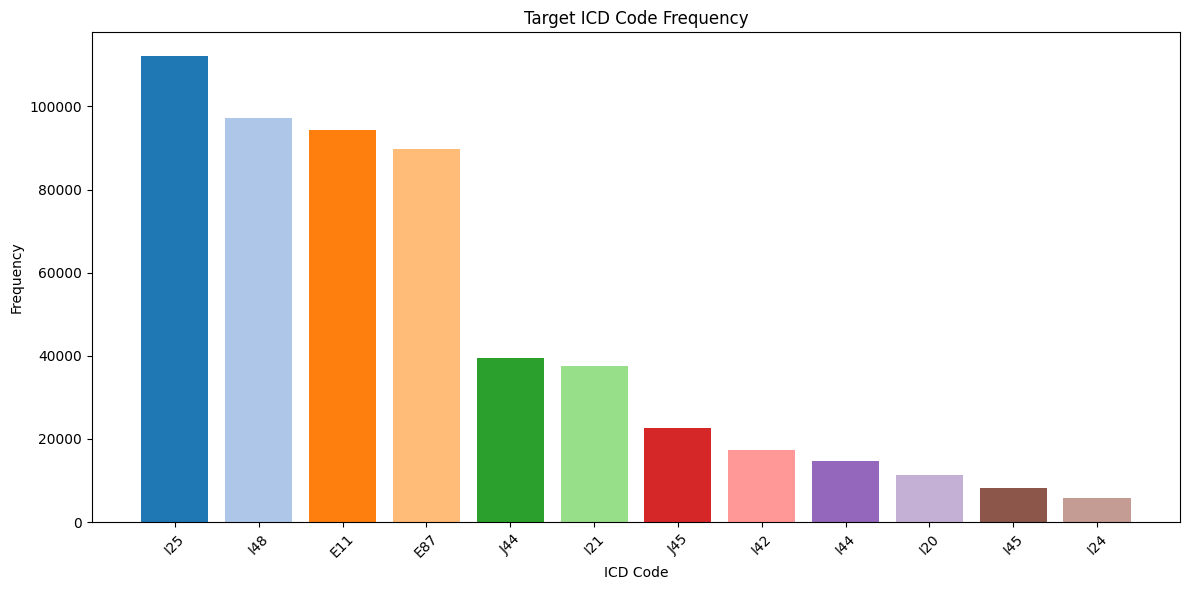

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Your list of ICD codes of interest
target_icd_codes = (
    "I481", "R000", "R001", "I210", "I200", "I20", "I21", "I24", "I25",
    "I42", "E87", "I48", "I44", "I45", "E1129", "E11", "J44", "J45"
)

# Example multilabel training set
y_train = df_rm_nan['label_train']

# Flatten and count only target ICDs
flat_icd_list = [code for sublist in y_train for code in sublist if code in target_icd_codes]
icd_counts = Counter(flat_icd_list)

# Create DataFrame (sorted by count)
df_icd = pd.DataFrame(icd_counts.items(), columns=["ICD Code", "Count"]).sort_values(by="Count", ascending=False)

# Assign different colors automatically
colors = plt.cm.tab20.colors  # You can also try 'Set3' or 'Pastel1' from matplotlib colormaps
bar_colors = [colors[i % len(colors)] for i in range(len(df_icd))]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_icd["ICD Code"], df_icd["Count"], color=bar_colors)
plt.xlabel("ICD Code")
plt.ylabel("Frequency")
plt.title("Target ICD Code Frequency")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Force whole number y-axis
plt.tight_layout()
plt.show()


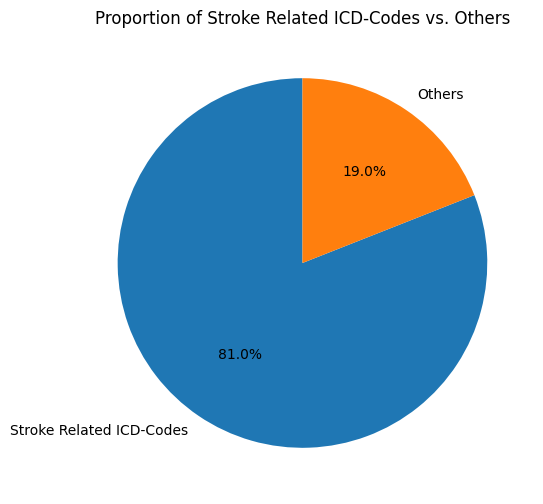

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df_rm_nan'
stroke_counts = df_rm_nan['stroke_yn'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
plt.pie(stroke_counts, labels=['Stroke Related ICD-Codes', 'Others'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Stroke Related ICD-Codes vs. Others')
plt.show()

### Step 4: Convert signals into numpy in  target-path/processed

In [ ]:
# (target_path/"processed").mkdir(parents=True, exist_ok=True)
# df,_,_,_=prepare_mimicecg(zip_file_path, target_folder=target_path/"processed")

## Step 5: Reformat as memmap for fast access


In [ ]:
# (target_path/"memmap").mkdir(parents=True, exist_ok=True)
# reformat_as_memmap(df, target_path/"memmap/memmap.npy", data_folder=target_path/"processed", annotation=True, max_len=0, delete_npys=True,col_data="data",col_lbl=None, batch_length=0, skip_export_signals=False)